In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from scipy import stats
from pathlib import Path, PureWindowsPath

In [2]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list

In [3]:
def compute_dsift(img):
    # To do
    # Create a sift object.
    sift = cv2.SIFT_create()

    # Stride and Size.
    stride = 5
    size = 8

    # # Make Keypoints where you want to calculate the Descriptor.
    X = (np.arange(0, img.shape[1] - size + 1, stride, dtype=np.float16) + size//2)
    Y = np.arange(0, img.shape[0] - size + 1, stride, dtype=np.float16) + size//2
    keypoints = [cv2.KeyPoint(x, y, size) for x in X for y in Y]

    # Make the descriptors for all the keypoints locations.
    keypoints, dense_feature = sift.compute(img, keypoints)

    return dense_feature

In [4]:
def get_tiny_image(img, output_size):
    # To do
    feature = cv2.resize(img,output_size)

    # Normalize the Image.
    feature = feature - np.mean(feature)
    feature = feature/ np.linalg.norm(feature)

    return feature

In [5]:
def predict_knn(feature_train, label_train, feature_test, k):
    # To do

    ## Initialize KNN
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(feature_train, label_train)

    # Make predictions.
    label_test_pred = neigh.predict(feature_test)
    
    return label_test_pred

In [6]:
def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do

    output_size = (16,16)

    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}

    # Convert all labels to Integers.
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])
    label_classes_int = np.array([label_map[item] for item in label_classes])

    # Get the tiny image of all the train items.
    feature_train = np.zeros((len(img_train_list), output_size[0]*output_size[1]))
    for i,path_img in enumerate(img_train_list):
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature_train[i,:] = get_tiny_image(img, output_size).flatten()   # Get features using tiny image funtion.

    # Get the tiny image of all the test items.
    feature_test = np.zeros((len(img_test_list), output_size[0]*output_size[1]))
    for i,path_img in enumerate(img_test_list):
        img = cv2.imread(path_img,0) # 0 to read as greyscale.
        feature_test[i,:] = get_tiny_image(img, output_size).flatten()
    
    # Predict labels for the test images.
    k_neighbour = 10
    label_test_pred = predict_knn(feature_train, label_test_int, feature_test, k_neighbour)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        indices = np.where(label_test_int == cls)[0]
        preds_temp = np.array([label_test_pred[i] for i in indices])
        for col in range(len(label_classes)):
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)

    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    visualize_confusion_matrix(confusion, accuracy, label_classes)

    return confusion, accuracy

In [7]:

# classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [8]:
def build_visual_dictionary(dense_feature_list, dict_size):
    # To do

    # List of features is passed stack them in a matrix.
    train_features = np.vstack(dense_feature_list)

    # Initialize a kmean object.
    kmeans = KMeans(n_clusters=dict_size, n_init=10 ,max_iter=100)

    # Fit the data into kmeans.
    kmeans.fit(train_features)

    # Get the Cluster Centers of teh items.
    vocab = kmeans.cluster_centers_

    # Save this VOCAB to a text file.
    np.savetxt('vocab.txt', vocab)

    return vocab

In [9]:
def compute_bow(feature, vocab):
    # To do

    # Initailize a nearest neighbour object.
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(vocab)
    distance, indices = neigh.kneighbors(feature)

    # Count the SIFT features that fall into each cluster of the vocab.
    bow_feature = np.bincount(indices[:,0], minlength=vocab.shape[0])

    # Normalize the bow_features.
    bow_feature = bow_feature / np.linalg.norm(bow_feature)

    return bow_feature

In [10]:
def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    
    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}

    # Convert all labels to integers.
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])
    label_classes_int = np.array([label_map[item] for item in label_classes])

    # Get Dense Features for all the training images.
    train_features = []
    for path_img in img_train_list:
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature = compute_dsift(img)
        train_features.append(feature)

    # Get Dense Features for all the test images.
    test_features = []
    for path_img in img_test_list:
        img = cv2.imread(path_img,0)
        feature = compute_dsift(img)
        test_features.append(feature)

    ## Build VOCAB from dense Features of Training Data.
    use_saved_file = True
    if use_saved_file:
        vocab = np.loadtxt('vocab.txt')
    else:
        dict_size = 60
        vocab = build_visual_dictionary(train_features, dict_size)

    # Build histograms for all the training data.
    histo_train = [compute_bow(feature, vocab) for feature in train_features]
    histo_train = np.vstack(histo_train)

    # Build histograms for all the test data. Compute BOW Does that for you.
    histo_test = [compute_bow(feature, vocab) for feature in test_features]
    histo_test = np.vstack(histo_test)

    # Predict labels for the test images.
    k_neighbour = 10
    label_test_pred = predict_knn(histo_train, label_test_int, histo_test, k_neighbour)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        indices = np.where(label_test_int == cls)[0]
        preds_temp = np.array([label_test_pred[i] for i in indices])
        for col in range(len(label_classes)):
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)

    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [11]:
# classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [12]:
def predict_svm(feature_train, label_train, feature_test, n_classes):
    # To do

    # Make Linear SVC Instance.
    clf = LinearSVC(C=1, dual='auto')   # C is regularization parameter are default.

    # Create Binary Labels for all the items.
    label_test_binary = np.zeros((n_classes,len(feature_test)))
    for i in range(1, n_classes+1):
        # Generate binary label for Current class
        label_train_i = (label_train == i).astype(int)
        clf.fit(feature_train, label_train_i)
        label_test_i = clf.decision_function(feature_test)
        label_test_binary[i-1,:] = label_test_i
    
    # Get the index of row with max score, +1 this is the predicted label.
    label_test_pred = np.argmax(label_test_binary, axis=0) + 1

    return label_test_pred


In [13]:
def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do

    # Map labels to integers.
    label_map = {key : value+1 for value, key in enumerate(label_classes)}

    # Convert all labels to integers.
    label_train_int = np.array([label_map[item] for item in label_train_list])
    label_test_int = np.array([label_map[item] for item in label_test_list])
    label_classes_int = np.array([label_map[item] for item in label_classes])

    # Get Dense Features for all the training images.
    train_features = []
    for path_img in img_train_list:
        img = cv2.imread(path_img,0) # Read Image, 0 to read as greyscale.
        feature = compute_dsift(img)
        train_features.append(feature)

    # Get Dense Features for all the test images.
    test_features = []
    for path_img in img_test_list:
        img = cv2.imread(path_img,0)
        feature = compute_dsift(img)
        test_features.append(feature)

    ## Build VOCAB from dense Features of Training Data.
    use_saved_file = True
    if use_saved_file:
        vocab = np.loadtxt('vocab.txt')
    else:
        dict_size = 60
        vocab = build_visual_dictionary(train_features, dict_size)

    # Build histograms for all the training data.
    histo_train = [compute_bow(feature, vocab) for feature in train_features]
    histo_train = np.vstack(histo_train)

    # Build histograms for all the test data. Compute BOW Does that for you.
    histo_test = [compute_bow(feature, vocab) for feature in test_features]
    histo_test = np.vstack(histo_test)

    # Get the Prediction from SVM Predictor.
    n_classes = 15
    label_test_pred = predict_svm(histo_train, label_train_int, histo_test, n_classes)

    # Make the confusion Matrix.
    confusion = np.zeros((len(label_classes), len(label_classes)))
    for row,cls in enumerate(label_classes_int):
        indices = np.where(label_test_int == cls)[0]
        preds_temp = np.array([label_test_pred[i] for i in indices])
        for col in range(len(label_classes)):
            confusion[row,col] = np.sum(preds_temp == label_classes_int[col]) / len(indices)

    # Find the accuracy as mean of the correct predictions.
    accuracy = np.mean(np.diagonal(confusion))

    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [14]:
# classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [15]:
def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


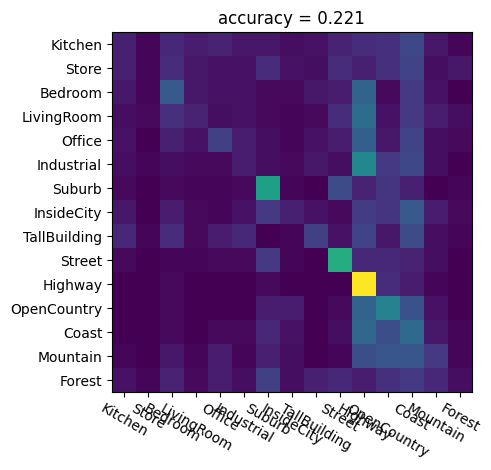

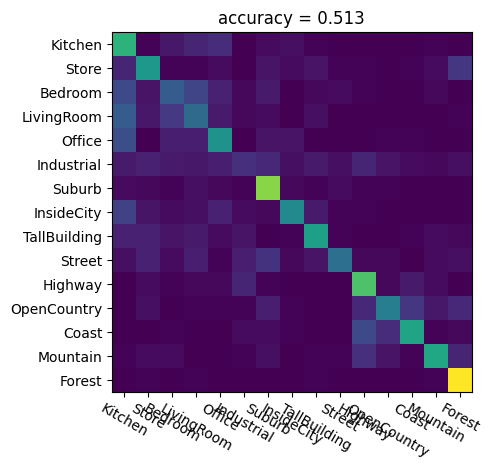

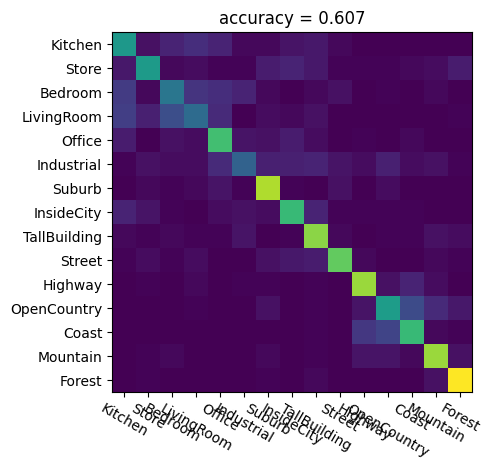

In [16]:
if __name__ == '__main__':
    # To do: replace with your dataset path
    label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")
    
    classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

    classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)
    
    classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)